Mounted at /content/drive
Usando KAG_WINDOW = 7 días
Batch pre-entrenamiento: 16, muestras totales: 17
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 - 5s - 5s/step - loss: 6.9236e-04 - val_loss: 0.2965
Epoch 2/20


1/1 - 0s - 172ms/step - loss: 3.7326e-04 - val_loss: 0.2843
Epoch 3/20


1/1 - 0s - 165ms/step - loss: 4.0141e-04 - val_loss: 0.2789
Epoch 4/20
1/1 - 0s - 242ms/step - loss: 4.9281e-04 - val_loss: 0.2796
Epoch 5/20
1/1 - 0s - 104ms/step - loss: 4.5121e-04 - val_loss: 0.2831
Epoch 6/20
1/1 - 0s - 142ms/step - loss: 3.8407e-04 - val_loss: 0.2875
Epoch 7/20
1/1 - 0s - 140ms/step - loss: 3.4215e-04 - val_loss: 0.2913
Epoch 8/20
1/1 - 0s - 106ms/step - loss: 3.4374e-04 - val_loss: 0.2936
Epoch 9/20
1/1 - 0s - 121ms/step - loss: 3.8438e-04 - val_loss: 0.2941
Epoch 10/20
1/1 - 0s - 104ms/step - loss: 4.0081e-04 - val_loss: 0.2929
Epoch 11/20
1/1 - 0s - 149ms/step - loss: 3.8761e-04 - val_loss: 0.2904
Epoch 12/20
1/1 - 0s - 107ms/step - loss: 3.6534e-04 - val_loss: 0.2871
Epoch 13/20
1/1 - 0s - 143ms/step - loss: 3.4348e-04 - val_loss: 0.2835
Epoch 14/20
1/1 - 0s - 102ms/step - loss: 3.3131e-04 - val_loss: 0.2802
Epoch 15/20


1/1 - 0s - 206ms/step - loss: 3.3519e-04 - val_loss: 0.2776
Epoch 16/20


1/1 - 0s - 337ms/step - loss: 3.6079e-04 - val_loss: 0.2760
Epoch 17/20


1/1 - 0s - 164ms/step - loss: 3.5725e-04 - val_loss: 0.2756
Epoch 18/20
1/1 - 0s - 247ms/step - loss: 3.4967e-04 - val_loss: 0.2760
Epoch 19/20
1/1 - 0s - 110ms/step - loss: 3.3957e-04 - val_loss: 0.2768
Epoch 20/20
1/1 - 0s - 139ms/step - loss: 3.2464e-04 - val_loss: 0.2778
Fine-tune: train=150, val=38, batch=16
Epoch 1/30
9/9 - 5s - 555ms/step - loss: 0.0404 - val_loss: 0.0498 - learning_rate: 1.0000e-04
Epoch 2/30
9/9 - 0s - 46ms/step - loss: 0.0345 - val_loss: 0.0493 - learning_rate: 1.0000e-04
Epoch 3/30
9/9 - 0s - 42ms/step - loss: 0.0405 - val_loss: 0.0492 - learning_rate: 1.0000e-04
Epoch 4/30
9/9 - 0s - 43ms/step - loss: 0.0389 - val_loss: 0.0491 - learning_rate: 1.0000e-04
Epoch 5/30
9/9 - 0s - 49ms/step - loss: 0.0359 - val_loss: 0.0488 - learning_rate: 1.0000e-04
Epoch 6/30
9/9 - 0s - 52ms/step - loss: 0.0288 - val_loss: 0.0486 - learning_rate: 1.0000e-04
Epoch 7/30
9/9 - 0s - 47ms/step - loss: 0.0413 - val_loss: 0.0485 - learning_rate: 1.0000e-04
Epoch 8/30
9/9 - 0s - 31ms

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
Validación → RMSE: 4.14, MAE: 3.42


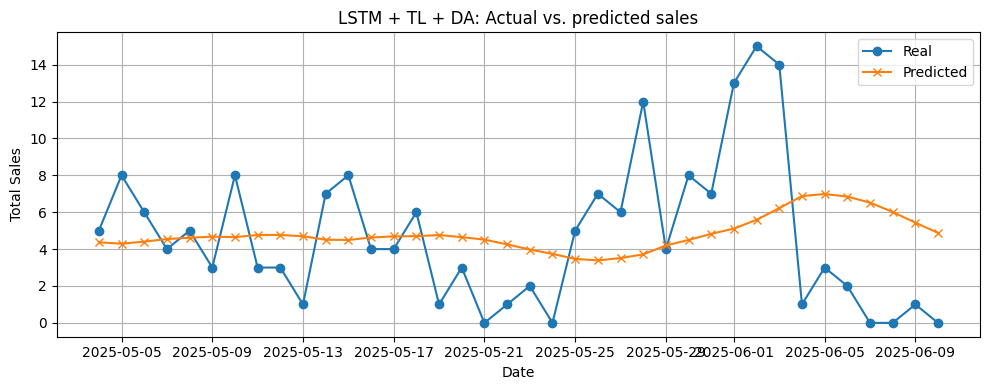

In [ ]:
# -----------------------------------
# Notebook: Pretrain Kaggle + Fine-tune con Data Augmentation
# -----------------------------------

# 1) Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2) Imports and routes
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

DATA_DIR  = '/content/drive/MyDrive/ecommerce_dashboard/data'
MODEL_DIR = '/content/drive/MyDrive/ecommerce_dashboard/models'
os.makedirs(MODEL_DIR, exist_ok=True)

# 3) Parameters
HORIZON     = 1
BATCH_SIZE  = 16
EPOCHS_PRE  = 20
EPOCHS_FINE = 30
LR_PRE      = 1e-3
LR_FINE     = 1e-4

# 4) functions
def create_windows(series, window, horizon):
    X, y = [], []
    for i in range(len(series) - window - horizon + 1):
        X.append(series[i:i+window])
        y.append(series[i+window+horizon-1])
    return np.array(X)[..., None], np.array(y)

def eval_metrics(model, X, y, scaler):
    p  = model.predict(X).flatten()
    t  = scaler.inverse_transform(y.reshape(-1,1)).flatten()
    pp = scaler.inverse_transform(p.reshape(-1,1)).flatten()
    return t, pp, sqrt(mean_squared_error(t,pp)), mean_absolute_error(t,pp)

# -----------------------------------
# A) PRE-TRAINING  Kaggle
# -----------------------------------

# 5) Loading and aggregating CSVs from Kaggle
mens   = pd.read_csv(f"{DATA_DIR}/ebay_mens_perfume.csv")
womens = pd.read_csv(f"{DATA_DIR}/ebay_womens_perfume.csv")
for df in (mens, womens):
# We remove the PDT timezone before parsing
    df['lastUpdated'] = pd.to_datetime(
        df['lastUpdated'].str.replace(r' [A-Z]+$', '', regex=True),
        errors='coerce'
    )
    df['day'] = df['lastUpdated'].dt.floor('d')

daily_m = mens.groupby('day')['sold'].sum()
daily_w = womens.groupby('day')['sold'].sum()
kag = daily_m.add(daily_w, fill_value=0) \
             .reindex(pd.date_range(daily_m.index.min(), daily_m.index.max(), freq='D'),
                      fill_value=0)

#6) Scaling and windows (short 7-day window)
scaler_k = MinMaxScaler()
yk = scaler_k.fit_transform(kag.values.reshape(-1,1)).flatten()

KAG_WINDOW = min(7, len(yk) - HORIZON - 1)
print(f"Usando KAG_WINDOW = {KAG_WINDOW} días")
Xk, yk = create_windows(yk, KAG_WINDOW, HORIZON)

bs_pre = min(BATCH_SIZE, len(Xk))
print(f"Batch pre-entrenamiento: {bs_pre}, muestras totales: {len(Xk)}")

# 7) Building and training the LSTM
model_pre = Sequential([
    LSTM(64, input_shape=(KAG_WINDOW,1), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])
model_pre.compile(optimizer=Adam(LR_PRE), loss='mean_squared_error')

cp = ModelCheckpoint(f"{MODEL_DIR}/pre_lstm.h5", save_best_only=True, monitor='val_loss')
history_pre = model_pre.fit(
    Xk, yk,
    epochs=EPOCHS_PRE,
    batch_size=bs_pre,
    validation_split=0.2,
    callbacks=[cp],
    verbose=2
)

# -----------------------------------
# B) FINE-TUNING in local dataset
# -----------------------------------

# 8) Data upload and preprocessing
df_local = pd.read_csv(f"{DATA_DIR}/combined_final.csv",
                       parse_dates=['day'], index_col='day') \
             .sort_index().fillna(0)
df_local = df_local[df_local['ignore']==False]

scaler_l = MinMaxScaler()
yl = scaler_l.fit_transform(df_local[['total_sales']]).flatten()

# Windows with WINDOW_L = 28 days (4 weeks)
WINDOW_L = 28
Xl, yl = create_windows(yl, WINDOW_L, HORIZON)
bs_fine = min(BATCH_SIZE, len(Xl))
split   = int(len(Xl)*0.8)
X_tr, X_va = Xl[:split], Xl[split:]
y_tr, y_va = yl[:split], yl[split:]
print(f"Fine-tune: train={len(X_tr)}, val={len(X_va)}, batch={bs_fine}")

# 9) Augmentation functions
def jitter(x, σ=0.005):
    return x + np.random.normal(0, σ, size=x.shape)

def permute(x, n=4):
    segs = np.array_split(x, n)
    np.random.shuffle(segs)
    return np.concatenate(segs)

aug_fns = [jitter, permute]

def gen_aug(X, y, batch):
    idx = np.arange(len(X))
    while True:
        np.random.shuffle(idx)
        for i in range(0, len(X), batch):
            b  = idx[i:i+batch]
            Xb = X[b].copy()
            yb = y[b]
            mask = np.random.rand(len(b)) < 0.2
            if mask.any():
                fns = np.random.choice(aug_fns, mask.sum())
                rows = np.nonzero(mask)[0]
                for fn, ridx in zip(fns, rows):
                    Xb[ridx, :, 0] = fn(Xb[ridx, :, 0])
            yield Xb, yb

#10) Pre-workout loading and total defrosting
model_ft = load_model(f"{MODEL_DIR}/pre_lstm.h5", compile=False)
for layer in model_ft.layers:
    layer.trainable = True

model_ft.compile(optimizer=Adam(LR_FINE), loss='mean_squared_error')
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history_ft = model_ft.fit(
    gen_aug(X_tr, y_tr, bs_fine),
    steps_per_epoch=len(X_tr)//bs_fine,
    validation_data=(X_va, y_va),
    epochs=EPOCHS_FINE,
    callbacks=[rlr],
    verbose=2
)

# -----------------------------------
# C) Evaluation and Graph
# -----------------------------------

t_va, p_va, rmse_va, mae_va = eval_metrics(model_ft, X_va, y_va, scaler_l)
print(f"Validación → RMSE: {rmse_va:.2f}, MAE: {mae_va:.2f}")

# Graph last 28 observations
dates_va = df_local.index[WINDOW_L+split : WINDOW_L+split+len(y_va)]
plt.figure(figsize=(10,4))
plt.plot(dates_va, t_va, marker='o', label='Real')
plt.plot(dates_va, p_va, marker='x', label='Predicted')
plt.title('LSTM + TL + DA: Actual vs. predicted sales')
plt.xlabel('Date'); plt.ylabel('Total Sales')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()